# Compare SSH from ROMS output and reanalysis


Compare: 
- roms area averaged sea level height above geoid
- sea level height above geoid along Dutch coast

Data:
- GLORYS12V2 downloaded from https://resources.marine.copernicus.eu/product-detail/GLOBAL_MULTIYEAR_PHY_001_030/INFORMATION
- GLORYS2V3 downloaded from Dewi workstation: /net/pc200008/nobackup/users/bars/GLORYS2V3
- ROMS output Tim downloaded from http://doi.org/10.4121/uuid:d9656541-ff40-45d0-8859-ac644b155dfb
- altimetry downloaded from https://resources.marine.copernicus.eu/product-detail/SEALEVEL_GLO_PHY_L4_MY_008_047/INFORMATION

For Tim's run with 1/8° resolution and  + GLORYS12v1

Dewi's runs with 1/4° and 1/8° resolution + GLORYS2V3

ROMS domain: 36°N to 62°N and -20°W to 10°E

In [1]:
# Import necessary packages

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.stats import linregress

## SSH averaged over the ROMS domain

In [2]:
# Import GLORYS12V1 reanalysis data
glorys12v1 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Glorys12v1/SSH/glorys12v1_annual.nc')


# Make extent of the Glorys12v1 data similar to ROMS
glorys12v1 = glorys12v1.where((glorys12v1.latitude > 36) & (glorys12v1.latitude < 62) & (glorys12v1.longitude > -20) & (glorys12v1.longitude < 10), drop = True)


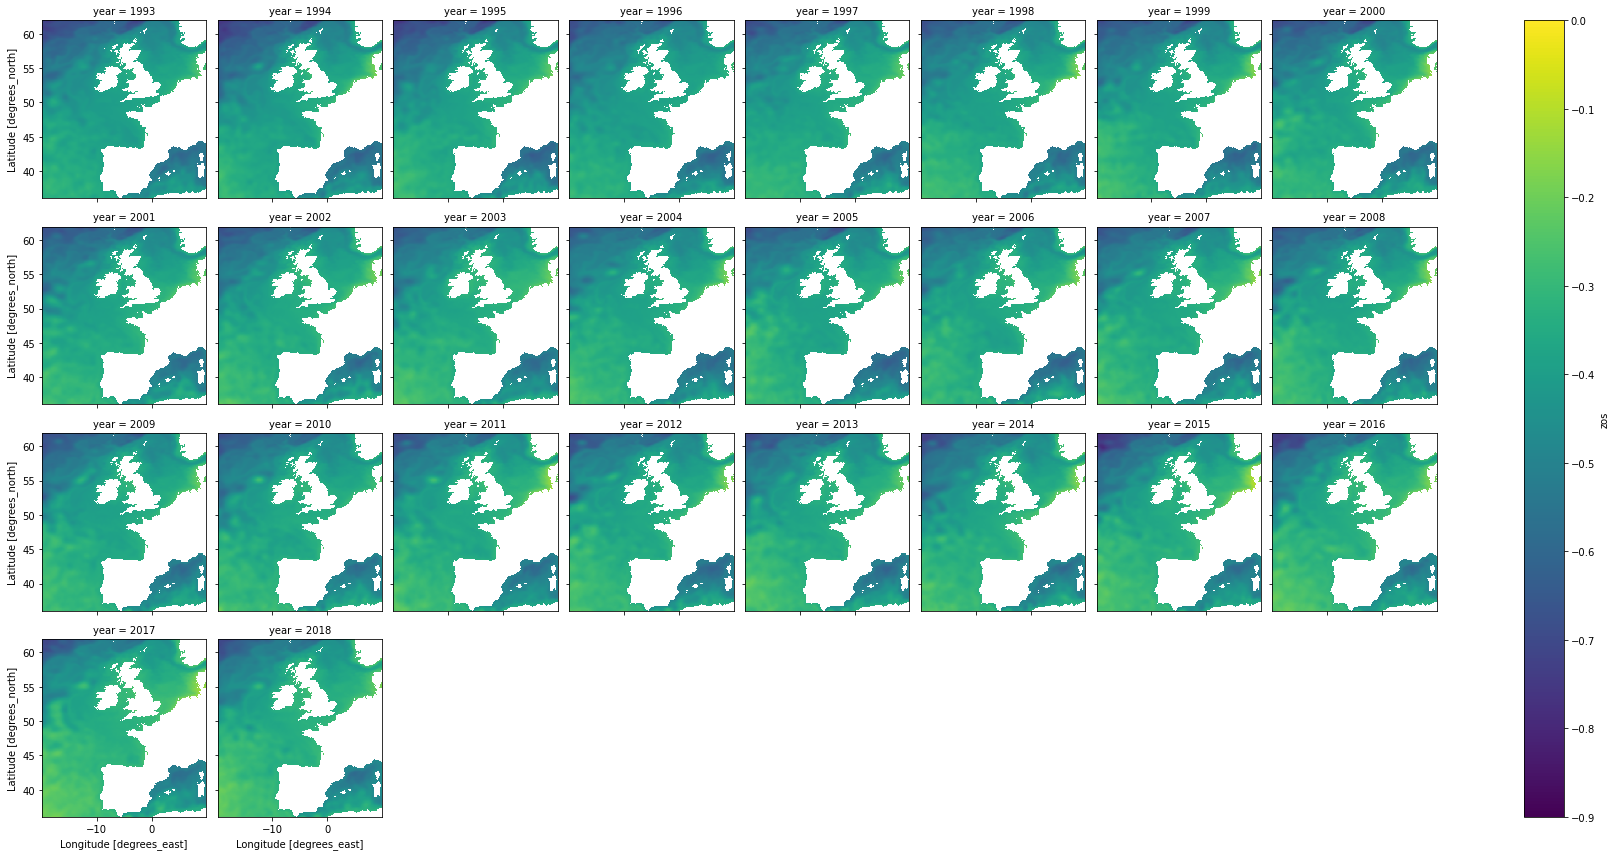

In [3]:
glorys12v1.zos.plot(col = 'year', col_wrap = 7, vmin = -0.9, vmax = 0) # Sea level [m]

In [4]:
# Import ROMS output from tim
roms_output_tim = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/Tim/ROMS_output_tim.nc')


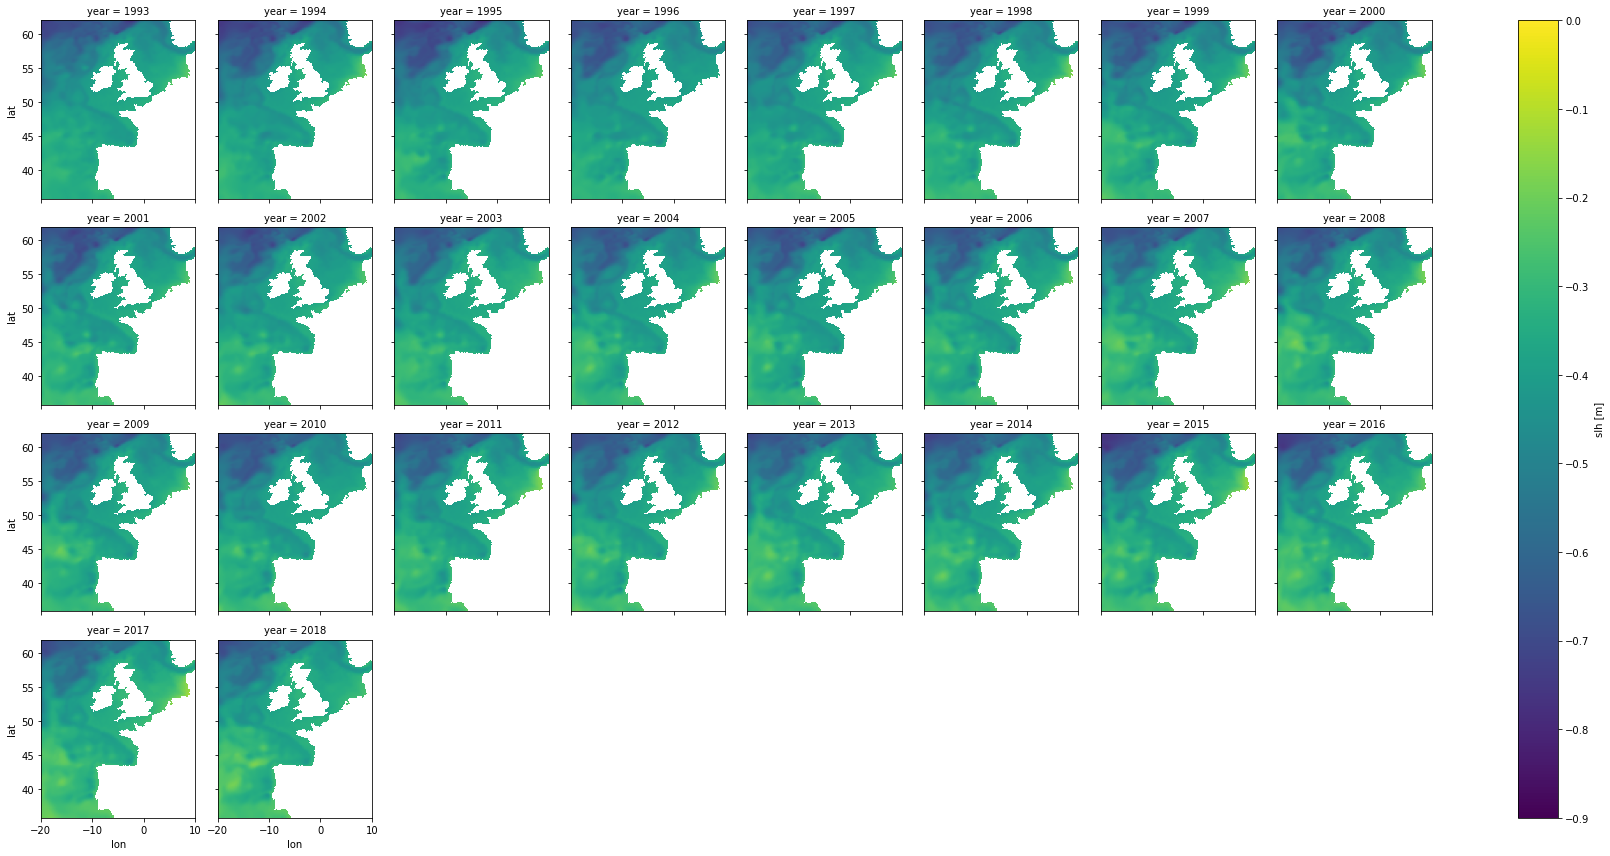

In [5]:
roms_output_tim.slh.plot(col = 'year', col_wrap = 7, vmin = -0.9, vmax = 0) # Sea level [m]

In [6]:
# Import altimetry data
cmems_altimetry = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/CMEMS altimetry/*.nc', parallel = True)

# Obtain annual averages
cmems_altimetry = cmems_altimetry.groupby('time.year').mean()

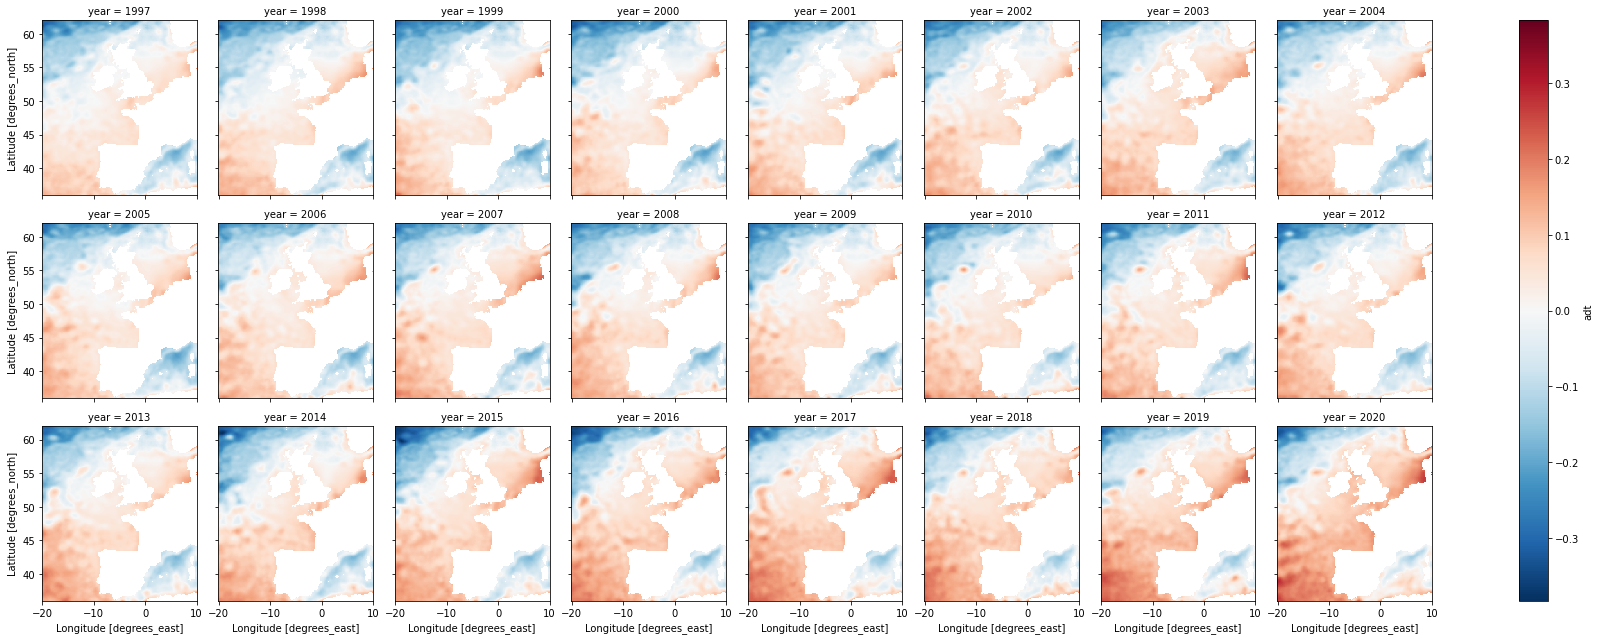

In [7]:
cmems_altimetry.adt.plot(col = 'year', col_wrap = 7) # Sea level [m]

In [8]:
def figure_ssh(data_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(data.year, data.values) for data in data_lst]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(data.year, data.values, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i], 3)} ± {round(se_lst[i], 3)} cm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(data.year, res_lst[i].intercept + trend_lst[i] * data.year, colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

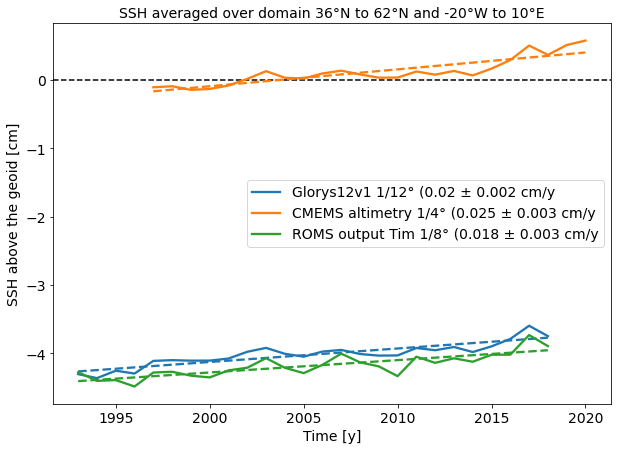

In [9]:
figure_ssh([glorys12v1.zos.mean('longitude').mean('latitude')*10, cmems_altimetry.adt.mean('longitude').mean('latitude')*10, roms_output_tim.slh.mean('lat').mean('lon')*10],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_glorys12_timoutput8')

In [10]:
# Obtain anomalies
glorys_anom = glorys12v1.zos.mean('longitude').mean('latitude') - glorys12v1.where(glorys12v1.year >= 1997, drop = True).mean('longitude').zos.mean('latitude').mean('year')
roms_tim_anom = roms_output_tim.slh.mean('lat').mean('lon') - roms_output_tim.where(roms_output_tim.year >= 1997, drop = True).slh.mean('lat').mean('lon').mean('year')
cmems_anom = cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').mean('year')

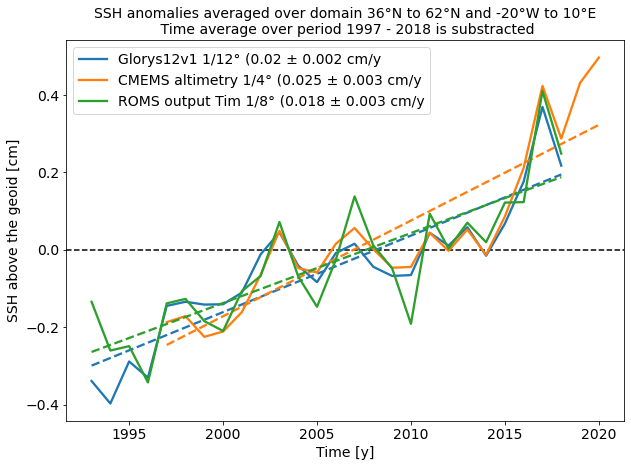

In [11]:
figure_ssh([glorys_anom*10, cmems_anom*10, roms_tim_anom*10],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2018 is substracted',
           'roms_area_averaged_ssh_anomalies_glorys12_timoutput8')

In [12]:
# Import GLORYS2V3
Glorys2v3_SSH = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/SSH/*.nc', parallel = True)
Glorys2v3_GRID2D = xr.open_mfdataset('/Users/iriskeizer/Documents/ROMS/data/GLORYS2V3/GRID2D/*.nc', parallel = True)

# Add the two datasets
Glorys2v3 = xr.concat([Glorys2v3_GRID2D, Glorys2v3_SSH], dim = 'time_counter')

# Obtain annual values
Glorys2v3 = Glorys2v3.groupby('time_counter.year').mean()


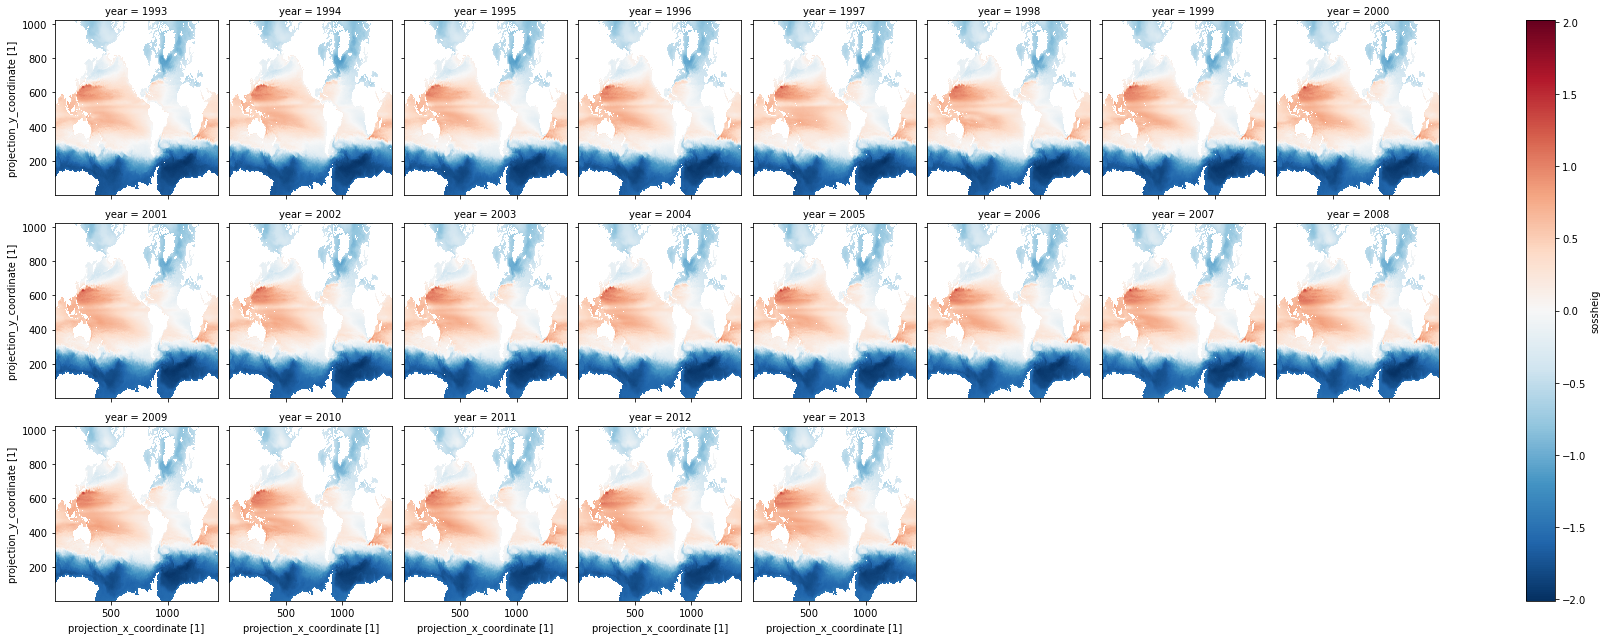

In [13]:
Glorys2v3.sossheig.plot(col = 'year', col_wrap = 7)

In [14]:
# Import ROMS output dewi
roms_output_dewi4_exp29 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi4_exp29.nc')
roms_output_dewi4_exp36 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi4_exp36.nc')
roms_output_dewi8 = xr.open_dataset('/Users/iriskeizer/Documents/ROMS/data/ROMS output Dewi/ROMS_output_dewi8.nc')


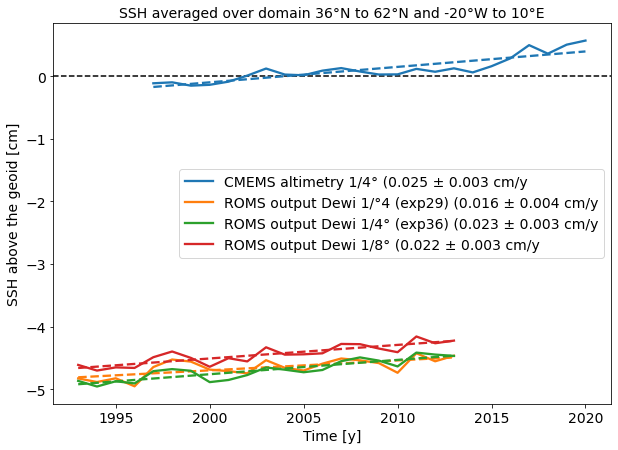

In [15]:
figure_ssh([cmems_altimetry.adt.mean('longitude').mean('latitude')*10, roms_output_dewi4_exp29.slh.mean('lat').mean('lon')*10, 
            roms_output_dewi4_exp36.slh.mean('lat').mean('lon')*10, roms_output_dewi8.slh.mean('lat').mean('lon')*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/°4 (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH averaged over domain 36°N to 62°N and -20°W to 10°E',
          'roms_area_averaged_ssh_glorys2v3_dewioutput')

In [16]:
# Obtain anomalies
roms4_exp29_anom = roms_output_dewi4_exp29.slh.mean('lat').mean('lon') - roms_output_dewi4_exp29.where(roms_output_dewi4_exp29.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')
roms4_exp36_anom = roms_output_dewi4_exp36.slh.mean('lat').mean('lon') - roms_output_dewi4_exp36.where(roms_output_dewi4_exp36.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')
roms8_anom = roms_output_dewi8.slh.mean('lat').mean('lon') - roms_output_dewi8.where(roms_output_dewi8.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')
cmems_anom = cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').mean('year')

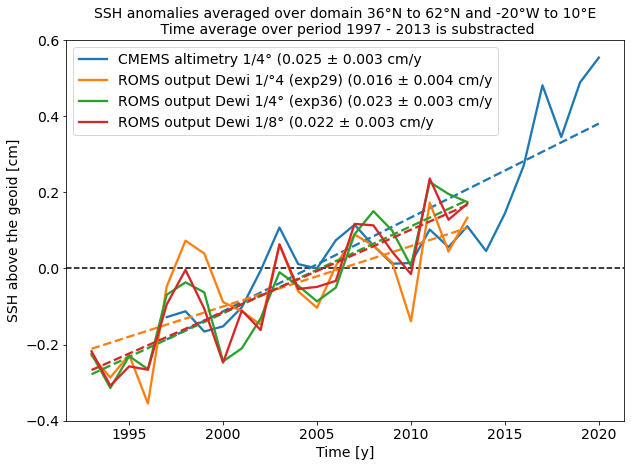

In [17]:
figure_ssh([cmems_anom*10, roms4_exp29_anom*10, roms4_exp36_anom*10, roms8_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/°4 (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2013 is substracted',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput')

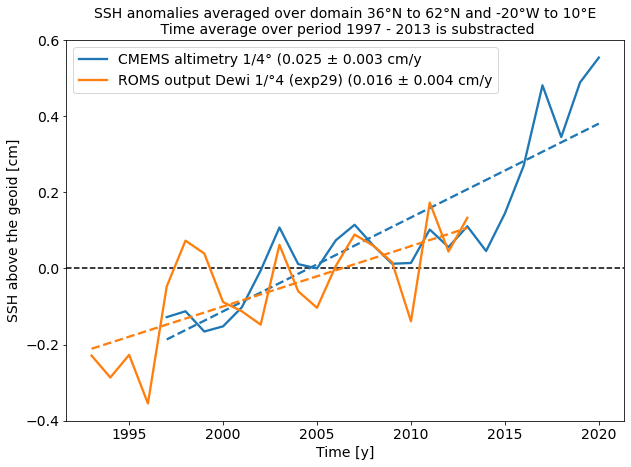

In [18]:
figure_ssh([cmems_anom*10, roms4_exp29_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/°4 (exp29)'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2013 is substracted',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_4_29')

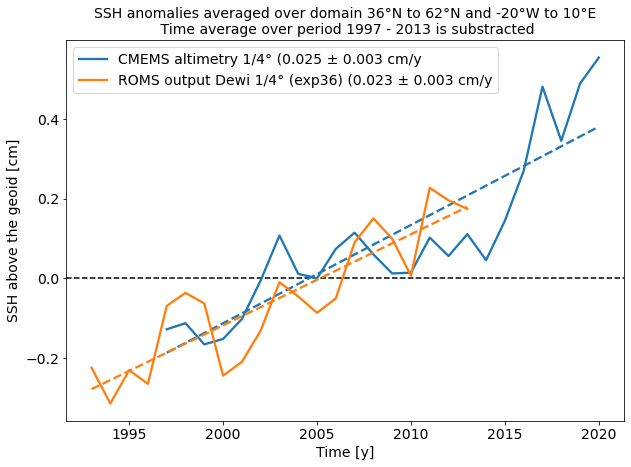

In [19]:
figure_ssh([cmems_anom*10, roms4_exp36_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp36)'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2013 is substracted',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_4_36')

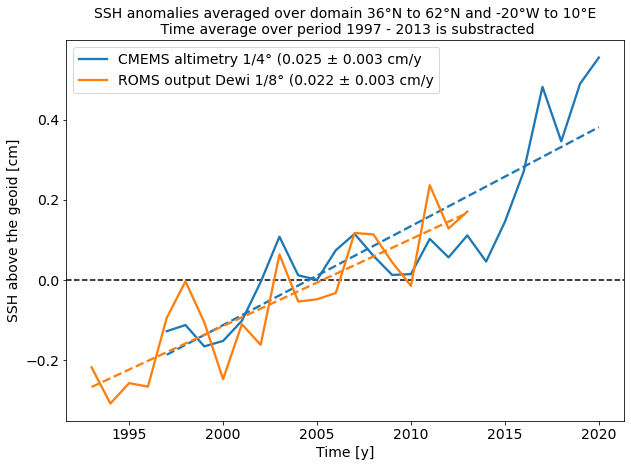

In [21]:
figure_ssh([cmems_anom*10, roms8_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/8°'],
           'SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n Time average over period 1997 - 2013 is substracted',
          'roms_area_averaged_ssh_anomalies_glorys2v3_dewioutput_8')

## SSH along the Dutch coast

#### For the Tim output and GLORYS12V1 data

In [22]:
# Import tide gauge coordinates
tg_coords = pd.read_csv('/Users/iriskeizer/Documents/Wind effect/Data/observations/Coordinates/tgstations.csv', index_col = 'station')

In [23]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the Glorys12v1 data

glorys12v1_stations = pd.DataFrame({'year':glorys12v1.zos.year.values})
glorys12v1_stations = glorys12v1_stations.set_index('year')

for station in tg_coords.index:
    
    glorys12v1_stations[station] = glorys12v1.zos.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
glorys12v1_stations['Average'] = glorys12v1_stations.mean(axis=1)

In [24]:
glorys12v1_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993   -0.294656        -0.294300   -0.301930       NaN  -0.283568 -0.289875   
1994   -0.249616        -0.250404   -0.254016       NaN  -0.232780 -0.239087   
1995   -0.265892        -0.266299   -0.276905       NaN  -0.257780 -0.263756   
1996   -0.342850        -0.337433   -0.345851       NaN  -0.339061 -0.338221   
1997   -0.279168        -0.273853   -0.280033       NaN  -0.262968 -0.268309   
1998   -0.240104        -0.239138   -0.243156       NaN  -0.218691 -0.227312   
1999   -0.248980        -0.247988   -0.251829       NaN  -0.226931 -0.236874   
2000   -0.236595        -0.236544   -0.239519       NaN  -0.214672 -0.223014   
2001   -0.255008        -0.253812   -0.264189       NaN  -0.247836 -0.250633   
2002   -0.255720        -0.251549   -0.252261       NaN  -0.236493 -0.241020   
2003   -0.271208        -0.264011   -0.265511       NaN  -0.248675 -0.258695   
2004   -0.250277        -0.250303   -0.255567       NaN  -0.232831 -0.240460   
2005   -0.276371        -0.274997   -0.285119       NaN  -0.264595 -0.272530   
2006   -0.251142        -0.246081   -0.249972       NaN  -0.228202 -0.236620   
2007   -0.235221        -0.237536   -0.245267       NaN  -0.220369 -0.231839   
2008   -0.254219        -0.251523   -0.250684       NaN  -0.226625 -0.237612   
2009   -0.268003        -0.265384   -0.267978       NaN  -0.249387 -0.257118   
2010   -0.299107        -0.294427   -0.306813       NaN  -0.296538 -0.296614   
2011   -0.232678        -0.230745   -0.229092       NaN  -0.203177 -0.218055   
2012   -0.249311        -0.246818   -0.248751       NaN  -0.227287 -0.235399   
2013   -0.265028        -0.261391   -0.268843       NaN  -0.254321 -0.256584   
2014   -0.230949        -0.228456   -0.229219       NaN  -0.211137 -0.215664   
2015   -0.201066        -0.198803   -0.199642       NaN  -0.170370 -0.184688   
2016   -0.235272        -0.231279   -0.236976       NaN  -0.219097 -0.224031   
2017   -0.207780        -0.206127   -0.210679       NaN  -0.184993 -0.196387   
2018   -0.271971        -0.267266   -0.270445       NaN  -0.256534 -0.261137   

       Average  
year            
1993 -0.292866  
1994 -0.245181  
1995 -0.266126  
1996 -0.340683  
1997 -0.272866  
1998 -0.233680  
1999 -0.242520  
2000 -0.230069  
2001 -0.254295  
2002 -0.247408  
2003 -0.261620  
2004 -0.245888  
2005 -0.274723  
2006 -0.242403  
2007 -0.234046  
2008 -0.244133  
2009 -0.261574  
2010 -0.298700  
2011 -0.222750  
2012 -0.241513  
2013 -0.261233  
2014 -0.223085  
2015 -0.190914  
2016 -0.229331  
2017 -0.201193  
2018 -0.265470

In [25]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

roms_output_tim_stations = pd.DataFrame({'year':roms_output_tim.slh.year.values})
roms_output_tim_stations = roms_output_tim_stations.set_index('year')

for station in tg_coords.index:
    
    roms_output_tim_stations[station] = roms_output_tim.slh.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
roms_output_tim_stations['Average'] = roms_output_tim_stations.mean(axis=1)

In [26]:
roms_output_tim_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993         NaN              NaN   -0.292273       NaN  -0.264440       NaN   
1994         NaN              NaN   -0.276727       NaN  -0.243143       NaN   
1995         NaN              NaN   -0.296957       NaN  -0.271790       NaN   
1996         NaN              NaN   -0.373942       NaN  -0.359973       NaN   
1997         NaN              NaN   -0.307426       NaN  -0.280557       NaN   
1998         NaN              NaN   -0.264999       NaN  -0.227811       NaN   
1999         NaN              NaN   -0.290612       NaN  -0.256689       NaN   
2000         NaN              NaN   -0.284223       NaN  -0.247067       NaN   
2001         NaN              NaN   -0.293355       NaN  -0.268001       NaN   
2002         NaN              NaN   -0.298780       NaN  -0.270177       NaN   
2003         NaN              NaN   -0.302142       NaN  -0.275163       NaN   
2004         NaN              NaN   -0.286379       NaN  -0.252054       NaN   
2005         NaN              NaN   -0.309228       NaN  -0.281919       NaN   
2006         NaN              NaN   -0.284566       NaN  -0.253011       NaN   
2007         NaN              NaN   -0.261265       NaN  -0.232969       NaN   
2008         NaN              NaN   -0.277575       NaN  -0.242331       NaN   
2009         NaN              NaN   -0.297348       NaN  -0.268072       NaN   
2010         NaN              NaN   -0.349728       NaN  -0.335381       NaN   
2011         NaN              NaN   -0.255585       NaN  -0.220709       NaN   
2012         NaN              NaN   -0.281163       NaN  -0.248825       NaN   
2013         NaN              NaN   -0.313650       NaN  -0.291285       NaN   
2014         NaN              NaN   -0.285435       NaN  -0.254387       NaN   
2015         NaN              NaN   -0.240302       NaN  -0.199819       NaN   
2016         NaN              NaN   -0.282324       NaN  -0.251005       NaN   
2017         NaN              NaN   -0.228950       NaN  -0.188285       NaN   
2018         NaN              NaN   -0.302175       NaN  -0.281598       NaN   

       Average  
year            
1993 -0.278357  
1994 -0.259935  
1995 -0.284374  
1996 -0.366958  
1997 -0.293992  
1998 -0.246405  
1999 -0.273651  
2000 -0.265645  
2001 -0.280678  
2002 -0.284478  
2003 -0.288653  
2004 -0.269217  
2005 -0.295573  
2006 -0.268788  
2007 -0.247117  
2008 -0.259953  
2009 -0.282710  
2010 -0.342554  
2011 -0.238147  
2012 -0.264994  
2013 -0.302467  
2014 -0.269911  
2015 -0.220060  
2016 -0.266664  
2017 -0.208617  
2018 -0.291887

Currently these dataframes also contain nan values which could be improved

either by making sure nearest non-nan data is selected
or take for all dataframes a few stations with non-nan values

In [28]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Tim

cmems_altimetry_stations = pd.DataFrame({'year':cmems_altimetry.year.values})
cmems_altimetry_stations = cmems_altimetry_stations.set_index('year')

for station in tg_coords.index:
    
    cmems_altimetry_stations[station] = cmems_altimetry.adt.sel(latitude = tg_coords['lat'][station], longitude = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
cmems_altimetry_stations['Average'] = cmems_altimetry_stations.mean(axis=1)

In [29]:
cmems_altimetry_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1997    0.076176         0.067230    0.064353       NaN   0.058639  0.070024   
1998    0.103489         0.092463    0.098358       NaN   0.116049  0.094206   
1999    0.067294         0.107371    0.087961       NaN   0.093949  0.098548   
2000    0.049831         0.070091    0.083949       NaN   0.083922  0.084373   
2001    0.086639         0.076344    0.082554       NaN   0.087376  0.083584   
2002    0.029587         0.070342    0.084507       NaN   0.082715  0.085953   
2003    0.115051         0.112706    0.100969       NaN   0.114923  0.099240   
2004    0.096884         0.094682    0.104210       NaN   0.113876  0.108375   
2005    0.112293         0.091555    0.076641       NaN   0.096767  0.075088   
2006    0.116509         0.096041    0.098464       NaN   0.118156  0.087695   
2007    0.098976         0.153512    0.163423       NaN   0.165773  0.172115   
2008    0.075861         0.091790    0.110258       NaN   0.110559  0.110113   
2009    0.075516         0.054491    0.079461       NaN   0.096901  0.052023   
2010    0.086750         0.096489    0.064366       NaN   0.074709  0.069628   
2011    0.084576         0.113715    0.113869       NaN   0.117585  0.107842   
2012    0.136893         0.078435    0.068672       NaN   0.076641  0.072077   
2013    0.103117         0.076865    0.072146       NaN   0.070737  0.073289   
2014    0.136252         0.108997    0.083650       NaN   0.079922  0.097386   
2015    0.164479         0.151841    0.119710       NaN   0.139230  0.117631   
2016    0.155948         0.120992    0.142390       NaN   0.139614  0.118606   
2017    0.201056         0.199739    0.165706       NaN   0.154590  0.190900   
2018    0.146907         0.081441    0.079846       NaN   0.080454  0.069997   
2019    0.192132         0.144145    0.144154       NaN   0.136510  0.147776   
2020    0.147407         0.163284    0.161150       NaN   0.167417  0.156969   

       Average  
year            
1997  0.067284  
1998  0.100913  
1999  0.091025  
2000  0.074433  
2001  0.083299  
2002  0.070621  
2003  0.108578  
2004  0.103605  
2005  0.090469  
2006  0.103373  
2007  0.150760  
2008  0.099716  
2009  0.071679  
2010  0.078388  
2011  0.107517  
2012  0.086544  
2013  0.079231  
2014  0.101241  
2015  0.138578  
2016  0.135510  
2017  0.182398  
2018  0.091729  
2019  0.152944  
2020  0.159246

In [30]:
def figure_ssh_coast(data_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(data.index, data.values) for data in data_lst]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(data.index, data.values, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i], 3)} ± {round(se_lst[i], 3)} cm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(data.index, res_lst[i].intercept + trend_lst[i] * data.index, colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

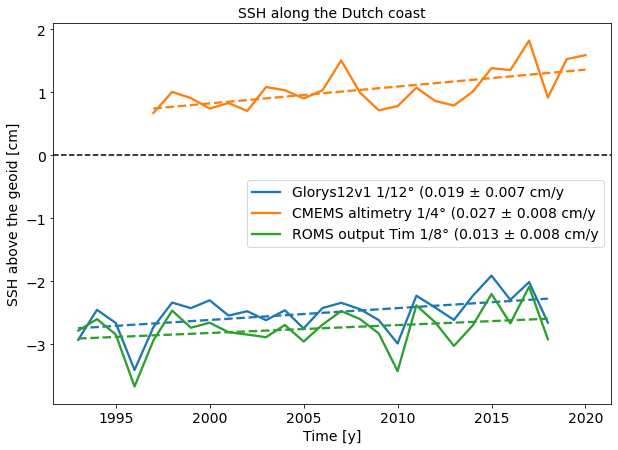

In [31]:
figure_ssh_coast([glorys12v1_stations['Average']*10, cmems_altimetry_stations['Average']*10, roms_output_tim_stations['Average']*10],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'SSH along the Dutch coast',
          'roms_dutch_coast_ssh_glorys12_timoutput8')

In [32]:
# Obtain anomalies by substracting the mean of overlap period
glorys_stat_anom = glorys12v1_stations['Average'] - glorys12v1_stations[4:]['Average'].mean()
roms_tim_stat_anom = roms_output_tim_stations['Average'] - roms_output_tim_stations[4:]['Average'].mean()
cmems_stat_anom = cmems_altimetry_stations['Average'] - cmems_altimetry_stations[:-2]['Average'].mean()

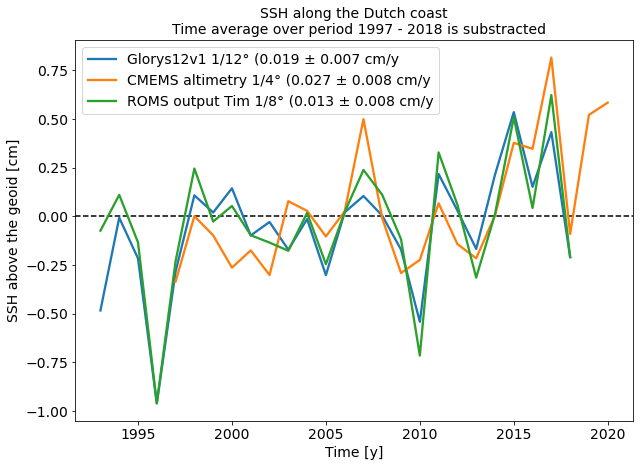

In [71]:
figure_ssh_coast([glorys_stat_anom*10, cmems_stat_anom*10, roms_tim_stat_anom*10],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'SSH along the Dutch coast\n  Time average over period 1997 - 2018 is substracted',
          'roms_dutch_coast_ssh_anomalies_glorys12_timoutput8', trends = False)

## SSH along the Dutch coast

#### For Dewi's output and GLORYS2V3 data

In [34]:
# Create DataFrame containing the timeseries along the Dutch coast for each tide gauge station for the ROMS output data from Dewi

roms_output_dewi8_stations = pd.DataFrame({'year':roms_output_dewi8.year.values})
roms_output_dewi8_stations = roms_output_dewi8_stations.set_index('year')

roms_output_dewi4_exp29_stations = roms_output_dewi8_stations.copy()
roms_output_dewi4_exp36_stations = roms_output_dewi8_stations.copy()


for station in tg_coords.index:
    
    roms_output_dewi8_stations[station] = roms_output_dewi8.slh.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method = 'Nearest').values
    roms_output_dewi4_exp29_stations[station] = roms_output_dewi4_exp29.slh.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method = 'Nearest').values
    roms_output_dewi4_exp36_stations[station] = roms_output_dewi4_exp36.slh.sel(lat = tg_coords['lat'][station], lon = tg_coords['lon'][station], method = 'Nearest').values
    
# obtain average
roms_output_dewi8_stations['Average'] = roms_output_dewi8_stations.mean(axis=1)
roms_output_dewi4_exp29_stations['Average'] = roms_output_dewi4_exp29_stations.mean(axis=1)
roms_output_dewi4_exp36_stations['Average'] = roms_output_dewi4_exp36_stations.mean(axis=1)

In [48]:
roms_output_dewi4_exp36_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993         NaN              NaN         NaN       NaN        NaN -0.398674   
1994         NaN              NaN         NaN       NaN        NaN -0.385706   
1995         NaN              NaN         NaN       NaN        NaN -0.387235   
1996         NaN              NaN         NaN       NaN        NaN -0.465063   
1997         NaN              NaN         NaN       NaN        NaN -0.412008   
1998         NaN              NaN         NaN       NaN        NaN -0.356097   
1999         NaN              NaN         NaN       NaN        NaN -0.374849   
2000         NaN              NaN         NaN       NaN        NaN -0.391641   
2001         NaN              NaN         NaN       NaN        NaN -0.401074   
2002         NaN              NaN         NaN       NaN        NaN -0.405764   
2003         NaN              NaN         NaN       NaN        NaN -0.402416   
2004         NaN              NaN         NaN       NaN        NaN -0.372849   
2005         NaN              NaN         NaN       NaN        NaN -0.396040   
2006         NaN              NaN         NaN       NaN        NaN -0.394973   
2007         NaN              NaN         NaN       NaN        NaN -0.358838   
2008         NaN              NaN         NaN       NaN        NaN -0.356486   
2009         NaN              NaN         NaN       NaN        NaN -0.379639   
2010         NaN              NaN         NaN       NaN        NaN -0.427458   
2011         NaN              NaN         NaN       NaN        NaN -0.349018   
2012         NaN              NaN         NaN       NaN        NaN -0.357535   
2013         NaN              NaN         NaN       NaN        NaN -0.402574   

       Average  
year            
1993 -0.398674  
1994 -0.385706  
1995 -0.387235  
1996 -0.465063  
1997 -0.412008  
1998 -0.356097  
1999 -0.374849  
2000 -0.391641  
2001 -0.401074  
2002 -0.405764  
2003 -0.402416  
2004 -0.372849  
2005 -0.396040  
2006 -0.394973  
2007 -0.358838  
2008 -0.356486  
2009 -0.379639  
2010 -0.427458  
2011 -0.349018  
2012 -0.357535  
2013 -0.402574

In [47]:
roms_output_dewi4_exp29_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993         NaN              NaN         NaN       NaN        NaN -0.399907   
1994         NaN              NaN         NaN       NaN        NaN -0.368690   
1995         NaN              NaN         NaN       NaN        NaN -0.376857   
1996         NaN              NaN         NaN       NaN        NaN -0.456639   
1997         NaN              NaN         NaN       NaN        NaN -0.386967   
1998         NaN              NaN         NaN       NaN        NaN -0.327672   
1999         NaN              NaN         NaN       NaN        NaN -0.348822   
2000         NaN              NaN         NaN       NaN        NaN -0.357592   
2001         NaN              NaN         NaN       NaN        NaN -0.376240   
2002         NaN              NaN         NaN       NaN        NaN -0.393729   
2003         NaN              NaN         NaN       NaN        NaN -0.375104   
2004         NaN              NaN         NaN       NaN        NaN -0.367218   
2005         NaN              NaN         NaN       NaN        NaN -0.383644   
2006         NaN              NaN         NaN       NaN        NaN -0.366576   
2007         NaN              NaN         NaN       NaN        NaN -0.352071   
2008         NaN              NaN         NaN       NaN        NaN -0.358108   
2009         NaN              NaN         NaN       NaN        NaN -0.382267   
2010         NaN              NaN         NaN       NaN        NaN -0.432530   
2011         NaN              NaN         NaN       NaN        NaN -0.342208   
2012         NaN              NaN         NaN       NaN        NaN -0.367163   
2013         NaN              NaN         NaN       NaN        NaN -0.398088   

       Average  
year            
1993 -0.399907  
1994 -0.368690  
1995 -0.376857  
1996 -0.456639  
1997 -0.386967  
1998 -0.327672  
1999 -0.348822  
2000 -0.357592  
2001 -0.376240  
2002 -0.393729  
2003 -0.375104  
2004 -0.367218  
2005 -0.383644  
2006 -0.366576  
2007 -0.352071  
2008 -0.358108  
2009 -0.382267  
2010 -0.432530  
2011 -0.342208  
2012 -0.367163  
2013 -0.398088

In [35]:
roms_output_dewi8_stations

Vlissingen  Hoek v. Holland  Den Helder  Delfzijl  Harlingen  IJmuiden  \
year                                                                           
1993         NaN              NaN   -0.351836       NaN  -0.327463       NaN   
1994         NaN              NaN   -0.328211       NaN  -0.294545       NaN   
1995         NaN              NaN   -0.342495       NaN  -0.315263       NaN   
1996         NaN              NaN   -0.407556       NaN  -0.392460       NaN   
1997         NaN              NaN   -0.347737       NaN  -0.322360       NaN   
1998         NaN              NaN   -0.292536       NaN  -0.255967       NaN   
1999         NaN              NaN   -0.318780       NaN  -0.284407       NaN   
2000         NaN              NaN   -0.335733       NaN  -0.297592       NaN   
2001         NaN              NaN   -0.333867       NaN  -0.308408       NaN   
2002         NaN              NaN   -0.349406       NaN  -0.320727       NaN   
2003         NaN              NaN   -0.334804       NaN  -0.307677       NaN   
2004         NaN              NaN   -0.316736       NaN  -0.283434       NaN   
2005         NaN              NaN   -0.337344       NaN  -0.310851       NaN   
2006         NaN              NaN   -0.331720       NaN  -0.298988       NaN   
2007         NaN              NaN   -0.303494       NaN  -0.275170       NaN   
2008         NaN              NaN   -0.304023       NaN  -0.268347       NaN   
2009         NaN              NaN   -0.327974       NaN  -0.298281       NaN   
2010         NaN              NaN   -0.375094       NaN  -0.358894       NaN   
2011         NaN              NaN   -0.284720       NaN  -0.249743       NaN   
2012         NaN              NaN   -0.313336       NaN  -0.280554       NaN   
2013         NaN              NaN   -0.345954       NaN  -0.326113       NaN   

       Average  
year            
1993 -0.339649  
1994 -0.311378  
1995 -0.328879  
1996 -0.400008  
1997 -0.335048  
1998 -0.274252  
1999 -0.301594  
2000 -0.316662  
2001 -0.321138  
2002 -0.335067  
2003 -0.321241  
2004 -0.300085  
2005 -0.324097  
2006 -0.315354  
2007 -0.289332  
2008 -0.286185  
2009 -0.313128  
2010 -0.366994  
2011 -0.267231  
2012 -0.296945  
2013 -0.336033

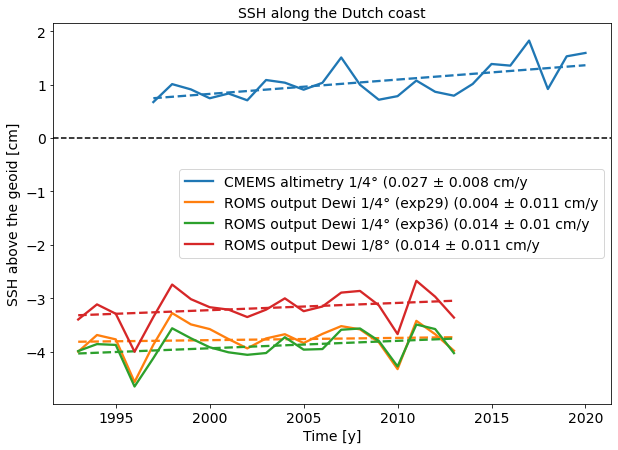

In [36]:
figure_ssh_coast([cmems_altimetry_stations['Average']*10, roms_output_dewi4_exp29_stations['Average']*10, roms_output_dewi4_exp36_stations['Average']*10, roms_output_dewi8_stations['Average']*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH along the Dutch coast',
          'roms_dutch_coast_ssh_glorys2v3_dewioutput')

In [37]:
# Obtain anomalies by substracting the mean of overlap period
roms_output_dewi8_stations_anom = roms_output_dewi8_stations['Average'] - roms_output_dewi8_stations[4:]['Average'].mean()
roms_output_dewi4_exp29_stations_anom = roms_output_dewi4_exp29_stations['Average'] - roms_output_dewi4_exp29_stations[4:]['Average'].mean()
roms_output_dewi4_exp36_stations_anom = roms_output_dewi4_exp36_stations['Average'] - roms_output_dewi4_exp36_stations[4:]['Average'].mean()
cmems_stat_anom2 = cmems_altimetry_stations['Average'] - cmems_altimetry_stations[:-7]['Average'].mean()

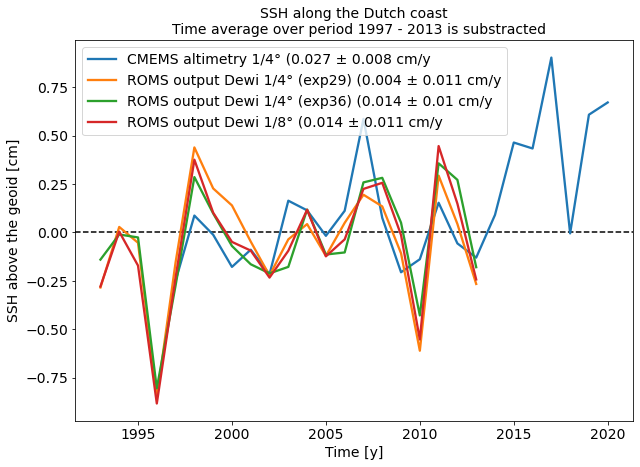

In [70]:
figure_ssh_coast([cmems_stat_anom2*10, roms_output_dewi4_exp29_stations_anom*10, roms_output_dewi4_exp36_stations_anom*10, roms_output_dewi8_stations_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'SSH along the Dutch coast\n  Time average over period 1997 - 2013 is substracted',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput', trends = False)

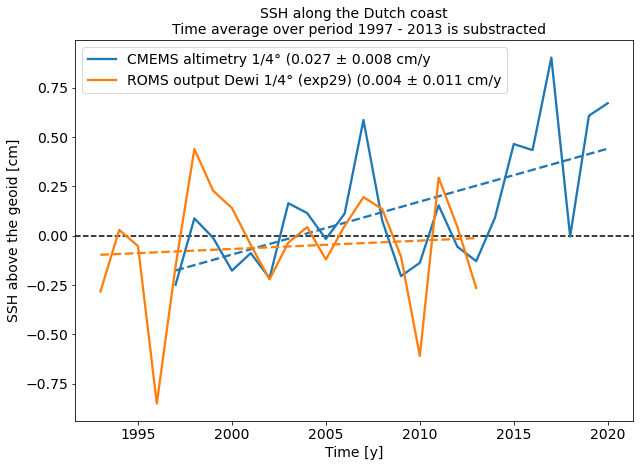

In [39]:
figure_ssh_coast([cmems_stat_anom2*10, roms_output_dewi4_exp29_stations_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)'],
           'SSH along the Dutch coast\n  Time average over period 1997 - 2013 is substracted',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_4_29')

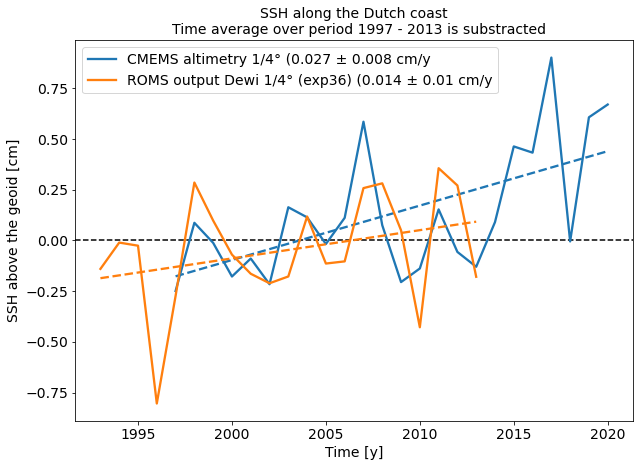

In [40]:
figure_ssh_coast([cmems_stat_anom2*10, roms_output_dewi4_exp36_stations_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp36)'],
           'SSH along the Dutch coast\n  Time average over period 1997 - 2013 is substracted',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_4_36')

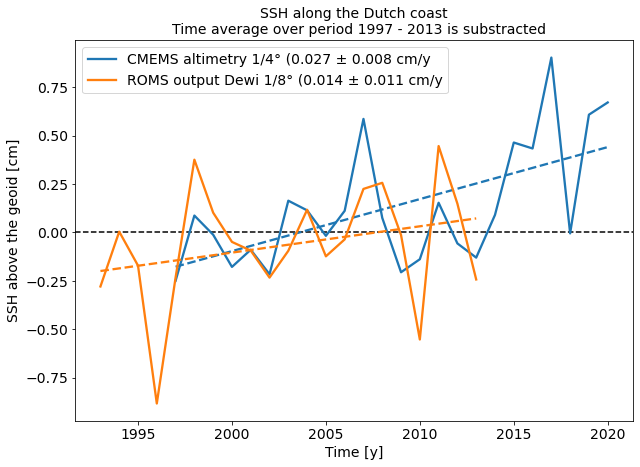

In [41]:
figure_ssh_coast([cmems_stat_anom2*10, roms_output_dewi8_stations_anom*10],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/8°'],
           'SSH along the Dutch coast\n  Time average over period 1997 - 2013 is substracted',
          'roms_dutch_coast_ssh_anomalies_glorys2v3_dewioutput_8')

## Difference between ROMS averaged sea level and sea level along the Dutch coast

#### For the Tim output and GLORYS12V1 data

In [54]:
def figure_ssh_difference(data_lst, time_lst, label_lst, fig_title, fig_name, trends = True):
    '''
    Function that creates a figure of the SSH over time and the trend of SSH
    data_lst should be a list containing the various data sets that should be plotted
    
    '''
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    

    plt.figure(figsize = (10,7))
    
    # Obtain trends
    res_lst = [linregress(time_lst[i], data) for i, data in enumerate(data_lst)]
    trend_lst = [res.slope for res in res_lst]
    se_lst = [res.stderr for res in res_lst]
    
    
    plt.axhline(color='k', linestyle='--', linewidth = 1.5)
    
    for i, data in enumerate(data_lst):
        
        # Plot the data
        plt.plot(time_lst[i], data, linewidth = 2.3, label = label_lst[i] + f' ({round(trend_lst[i], 3)} ± {round(se_lst[i], 3)} cm/y)')
        
        # Plot its trend in the same color
        if trends:
            plt.plot(time_lst[i], res_lst[i].intercept + trend_lst[i] * time_lst[i], colors[i], linestyle = '--', linewidth = 2.3)
        
        plt.xlabel('Time [y]', fontsize =  14)
        plt.ylabel('SSH above the geoid [cm]', fontsize = 14)
        plt.title(fig_title, fontsize = 14)

        plt.legend(fontsize = 14)
        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.savefig(f'/Users/iriskeizer/Documents/ROMS/figures/pre-analysis/reanalysis_vs_roms/{fig_name}')

In [43]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys12v1_difference = glorys12v1.zos.mean('longitude').mean('latitude').values - glorys12v1_stations['Average'].values
roms_output_tim_difference = roms_output_tim.slh.mean('lat').mean('lon').values - roms_output_tim_stations['Average'].values
cmems_altimetry_difference = cmems_altimetry.adt.mean('longitude').mean('latitude').values - cmems_altimetry_stations['Average'].values

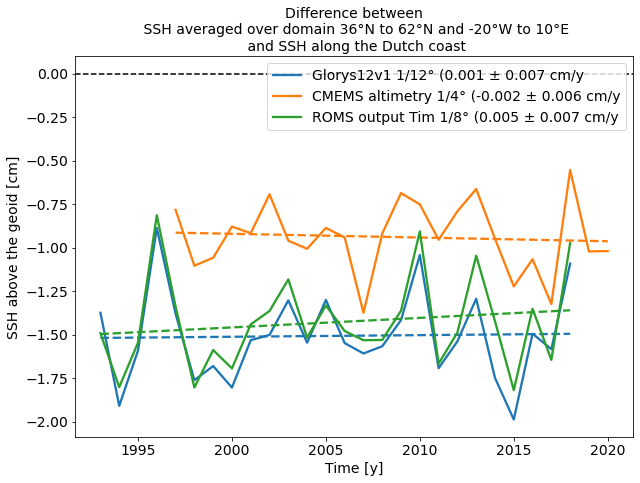

In [44]:
figure_ssh_difference([glorys12v1_difference*10, cmems_altimetry_difference*10, roms_output_tim_difference*10],
           [glorys12v1.year, cmems_altimetry.year, roms_output_tim.year],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast',
          'roms_difference_ssh_glorys12_timoutput8')

#### Differences for anomalies

In [45]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

glorys_difference_anom = (glorys12v1.zos.mean('longitude').mean('latitude') - glorys12v1.where(glorys12v1.year >= 1997, drop = True).mean('longitude').zos.mean('latitude').mean('year')) - (glorys12v1_stations['Average'] - glorys12v1_stations[4:]['Average'].mean())
roms_tim_difference_anom = (roms_output_tim.slh.mean('lat').mean('lon') - roms_output_tim.where(roms_output_tim.year >= 1997, drop = True).slh.mean('lat').mean('lon').mean('year')) - (roms_output_tim_stations['Average'] - roms_output_tim_stations[4:]['Average'].mean())
cmems_difference_anom = (cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2018, drop = True).adt.mean('longitude').mean('latitude').mean('year')) - (cmems_altimetry_stations['Average'] - cmems_altimetry_stations[:-2]['Average'].mean())

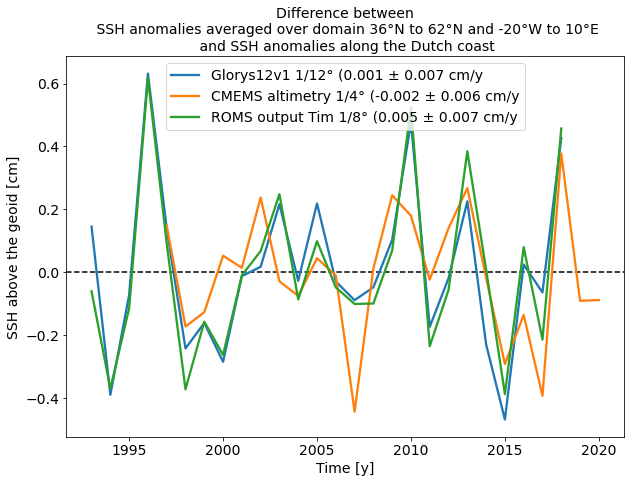

In [69]:
figure_ssh_difference([glorys_difference_anom*10, cmems_difference_anom*10, roms_tim_difference_anom*10],
           [glorys12v1.year, cmems_altimetry.year, roms_output_tim.year],
          ['Glorys12v1 1/12°', 'CMEMS altimetry 1/4°', 'ROMS output Tim 1/8°'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys12_timoutput8', trends = False)

## Difference between ROMS averaged sea level and sea level along the Dutch coast

#### For Dewi's output and GLORYS2V3 data

In [51]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

cmems_altimetry_difference = cmems_altimetry.adt.mean('longitude').mean('latitude').values - cmems_altimetry_stations['Average'].values
roms_output_dewi4_exp29_difference = roms_output_dewi4_exp29.slh.mean('lat').mean('lon').values - roms_output_dewi4_exp29_stations['Average'].values
roms_output_dewi4_exp36_difference = roms_output_dewi4_exp36.slh.mean('lat').mean('lon').values - roms_output_dewi4_exp36_stations['Average'].values
roms_output_dewi8_difference = roms_output_dewi8.slh.mean('lat').mean('lon').values - roms_output_dewi8_stations['Average'].values



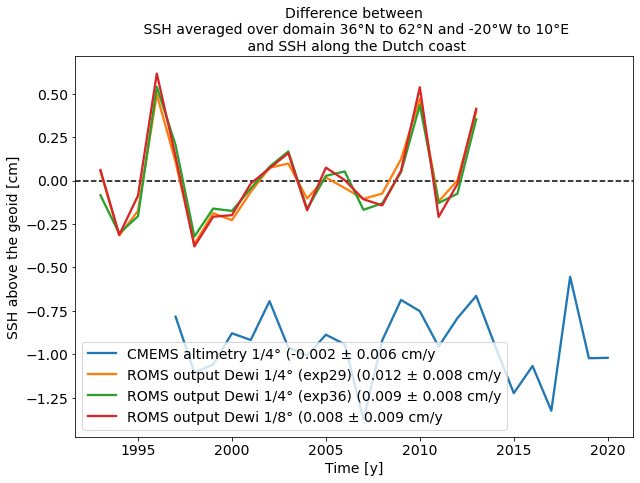

In [67]:
figure_ssh_difference([cmems_altimetry_difference*10, roms_output_dewi4_exp29_difference*10, roms_output_dewi4_exp36_difference*10, roms_output_dewi8_difference*10],
           [cmems_altimetry.year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast',
          'roms_difference_ssh_glorys2v3_dewioutput', trends = False)

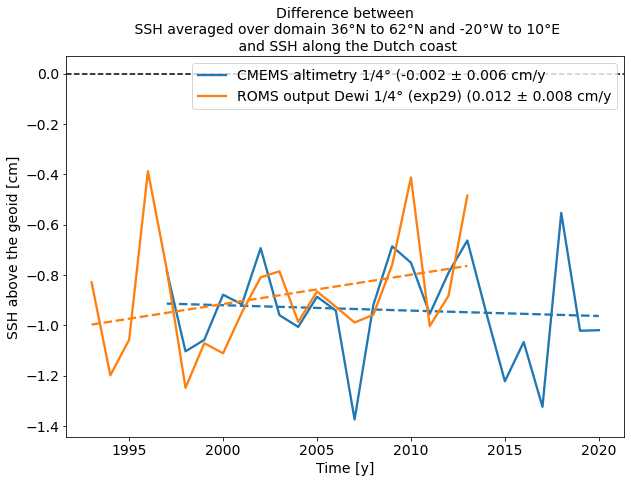

In [56]:
figure_ssh_difference([cmems_altimetry_difference*10, roms_output_dewi4_exp29_difference*10],
           [cmems_altimetry.year, roms_output_dewi4_exp29.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)'],
           'Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast',
          'roms_difference_ssh_glorys2v3_dewioutput_4_29')

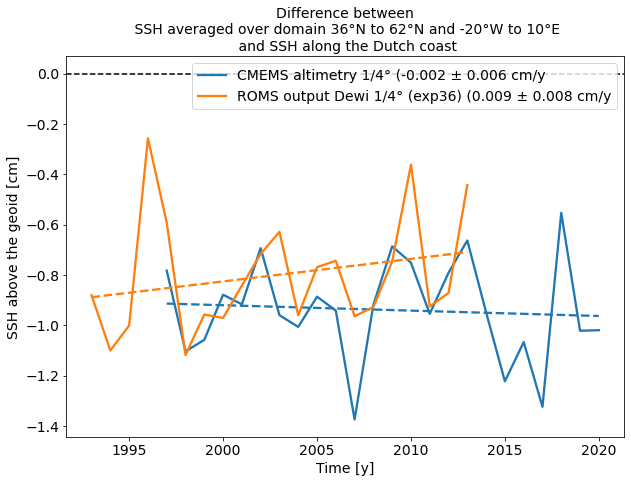

In [57]:
figure_ssh_difference([cmems_altimetry_difference*10, roms_output_dewi4_exp36_difference*10],
           [cmems_altimetry.year, roms_output_dewi4_exp36.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp36)'],
           'Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast',
          'roms_difference_ssh_glorys2v3_dewioutput_4_36')

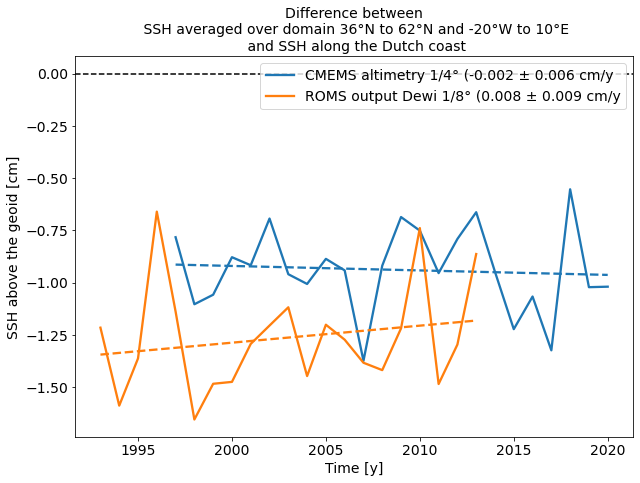

In [58]:
figure_ssh_difference([cmems_altimetry_difference*10, roms_output_dewi8_difference*10],
           [cmems_altimetry.year, roms_output_dewi8.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH along the Dutch coast',
          'roms_difference_ssh_glorys2v3_dewioutput_8')

#### Differences for anomalies

In [62]:
# Obtain differences by substracting the sea level along the Dutch coast from the domain mean 

cmems_difference_anom2 = (cmems_altimetry.adt.mean('longitude').mean('latitude') - cmems_altimetry.where(cmems_altimetry.year <= 2013, drop = True).adt.mean('longitude').mean('latitude').mean('year')) - (cmems_altimetry_stations['Average'] - cmems_altimetry_stations[:-2]['Average'].mean())
roms_output_dewi4_exp29_difference_anom = (roms_output_dewi4_exp29.slh.mean('lat').mean('lon') - roms_output_dewi4_exp29.where(roms_output_dewi4_exp29.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')) - (roms_output_dewi4_exp29_stations['Average'] - roms_output_dewi4_exp29_stations[4:]['Average'].mean())
roms_output_dewi4_exp36_difference_anom = (roms_output_dewi4_exp36.slh.mean('lat').mean('lon') - roms_output_dewi4_exp36.where(roms_output_dewi4_exp36.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')) - (roms_output_dewi4_exp36_stations['Average'] - roms_output_dewi4_exp36_stations[4:]['Average'].mean())
roms_output_dewi8_difference_anom = (roms_output_dewi8.slh.mean('lat').mean('lon') - roms_output_dewi8.where(roms_output_dewi8.year>=1997, drop = True).slh.mean('lat').mean('lon').mean('year')) - (roms_output_dewi8_stations['Average'] - roms_output_dewi8_stations[4:]['Average'].mean())




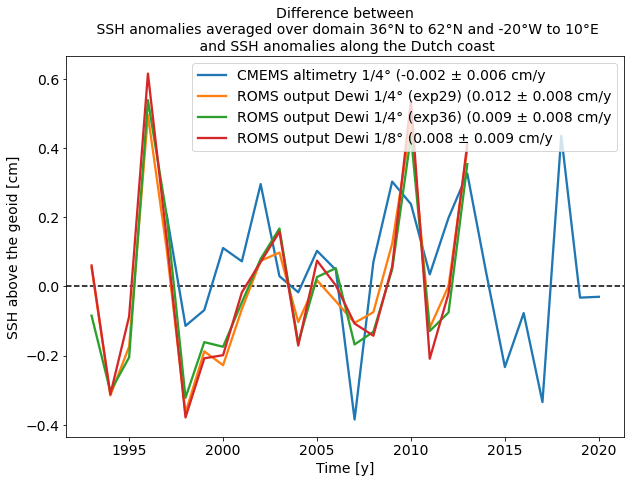

In [68]:
figure_ssh_difference([cmems_difference_anom2*10, roms_output_dewi4_exp29_difference_anom*10, roms_output_dewi4_exp36_difference_anom*10, roms_output_dewi8_difference_anom*10],
           [cmems_altimetry.year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)', 'ROMS output Dewi 1/4° (exp36)', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput', trends = False)

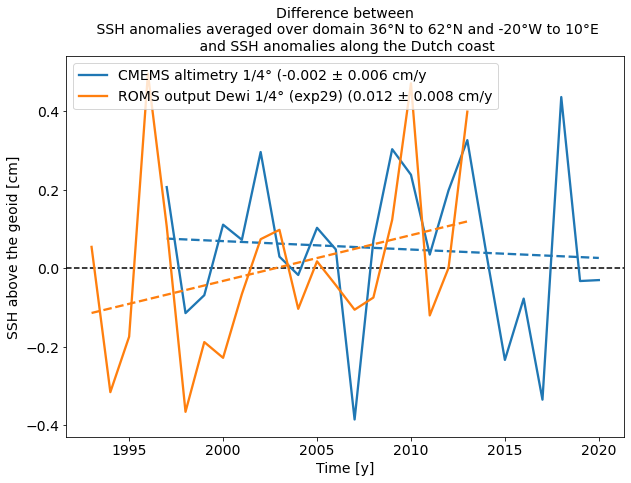

In [64]:
figure_ssh_difference([cmems_difference_anom2*10, roms_output_dewi4_exp29_difference_anom*10],
           [cmems_altimetry.year, roms_output_dewi4_exp29.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp29)'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_4_29')

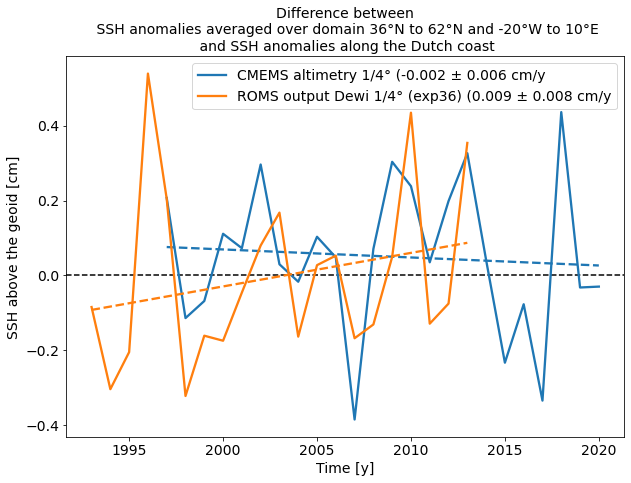

In [65]:
figure_ssh_difference([cmems_difference_anom2*10, roms_output_dewi4_exp36_difference_anom*10],
           [cmems_altimetry.year, roms_output_dewi4_exp29.year, roms_output_dewi4_exp36.year, roms_output_dewi8.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/4° (exp36)'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_4_36')

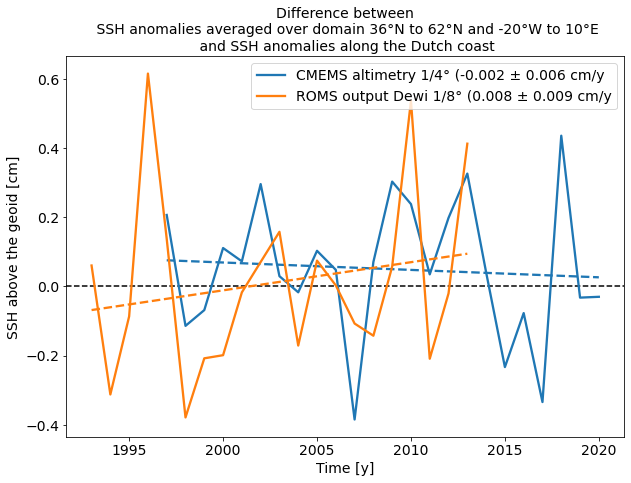

In [66]:
figure_ssh_difference([cmems_difference_anom2*10, roms_output_dewi8_difference_anom*10],
           [cmems_altimetry.year, roms_output_dewi8.year],
          ['CMEMS altimetry 1/4°', 'ROMS output Dewi 1/8°'],
           'Difference between\n SSH anomalies averaged over domain 36°N to 62°N and -20°W to 10°E\n and SSH anomalies along the Dutch coast',
          'roms_difference_ssh_anomalies_glorys2v3_dewioutput_8')